# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

El proyecto se encuentra disponible en el siguiente [repositorio](https://github.com/ricardoleoncorreia/amazon-review-score-predictor) de Github.

A continuación:

* Se importarán las librerías necesarias para el análisis.
* Se definirán las contantes y funciones a usar (`max_features` se fijó por motivos de optimización de recursos de hardware).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from time import time
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

random_state = 2021-1-30
fontsize = 16
base_sample = 10000
max_features = 2000
nlp = spacy.load("es_core_news_sm")

def print_elapsed_minutes(start_time):
    minutes_count = (time() - start_time) / 60
    print(f"{minutes_count:.2f} min")

Se importan los datos de entrenamiento y se visualizarán las primeras 5 filas:

In [2]:
reviews_train_data = pd.read_json("./data/dataset_es_train.json", lines=True)
reviews_train_data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


### Análisis exploratorio de datos

In [3]:
reviews_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.2+ MB


Se puede ver que no existen valores nulos y la única columna numérica es el número de estrellas de la reseña.
Un gráfico de barras ayudará a visualizar el tipo de problema presentado:

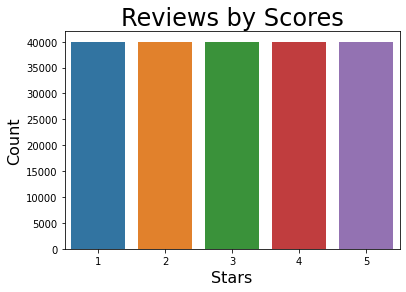

In [4]:
g = sns.countplot(x="stars", data=reviews_train_data)
g.axes.set_title("Reviews by Scores", fontsize = 1.5 * fontsize)
g.set_xlabel("Stars", fontsize=fontsize)
g.set_ylabel("Count", fontsize=fontsize)
plt.show()

De la figura anterior se puede deducir que se trata de un problema de **clasificación balanceado con múltiples clases**.
Ya que no existe preferencia entre una clase u otra, se usará el **accuracy** como métrica.
Las siguientes figuras podrán dar un mejor contexto de los datos.

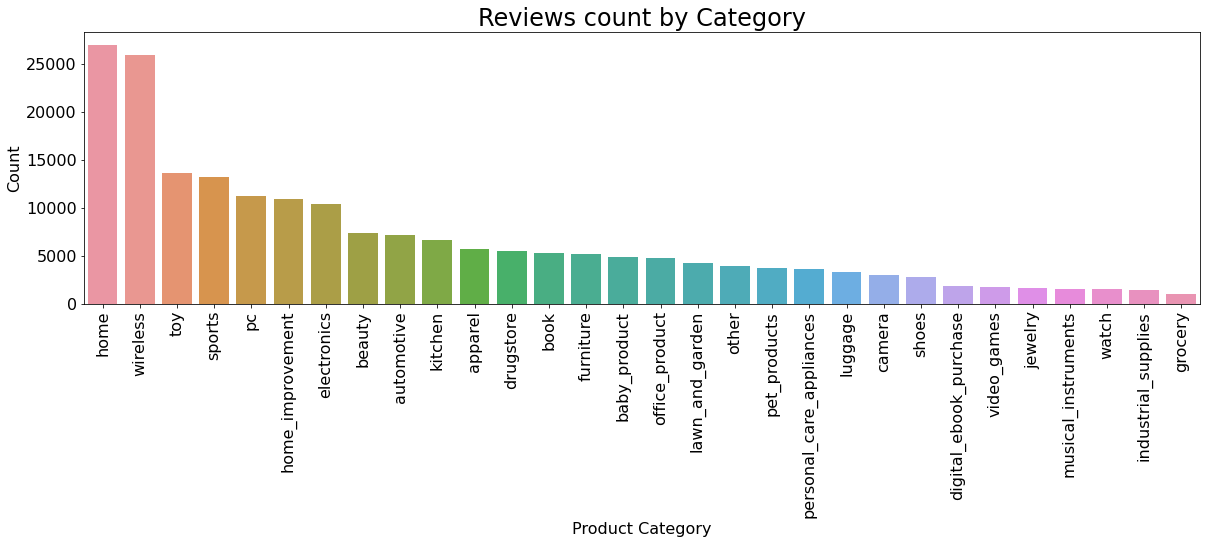

In [5]:
order = reviews_train_data["product_category"].value_counts().index
plt.figure(figsize=(20, 5))

g = sns.countplot(x="product_category", data=reviews_train_data, order=order)
g.axes.set_title("Reviews count by Category", fontsize = 1.5 * fontsize)
g.set_xlabel("Product Category", fontsize=fontsize)
g.set_ylabel("Count", fontsize=fontsize)
g.tick_params(labelsize=fontsize)

plt.xticks(rotation=90)
plt.show()

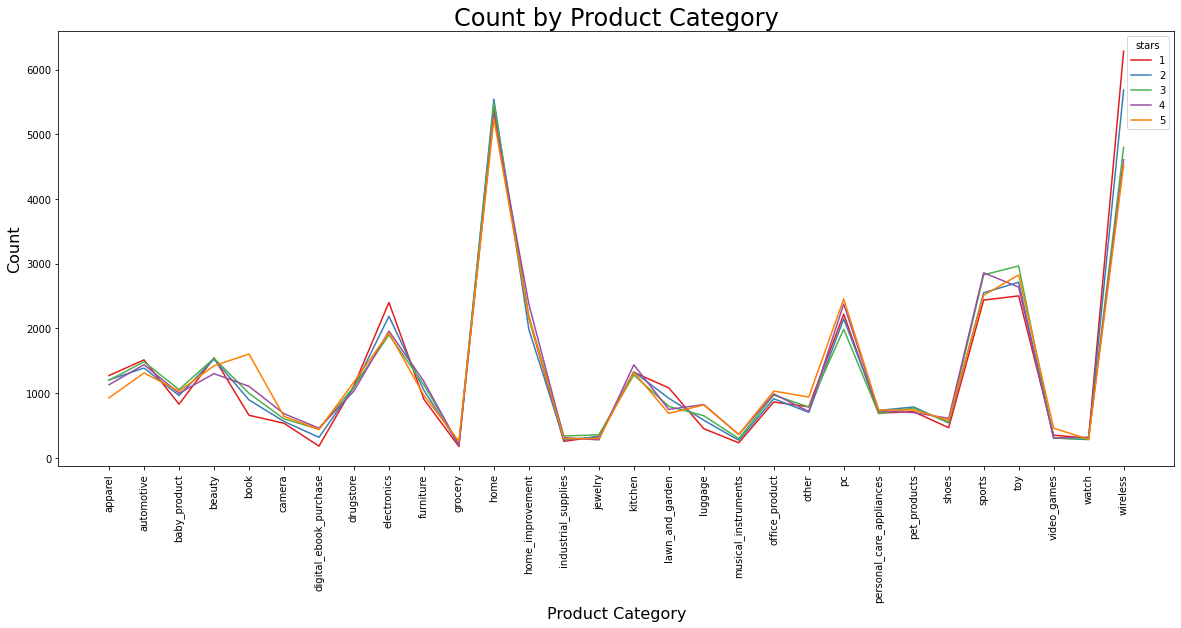

In [6]:
reviews_count = reviews_train_data[["product_category", "stars"]]\
                    .groupby(["product_category", "stars"])["product_category"]\
                    .count()\
                    .reset_index(name="count")\
                    .copy()

plt.figure(figsize=(20, 8))
g = sns.lineplot(data=reviews_count, x="product_category", y="count", hue="stars", palette = "Set1")
g.axes.set_title("Count by Product Category", fontsize = 1.5 * fontsize)
g.set_xlabel("Product Category", fontsize=fontsize)
g.set_ylabel("Count", fontsize=fontsize)
plt.xticks(rotation=90)
plt.show()

Se puede evidenciar que existe una gran cantidad de reseñas para las categorías `Home` y `Wireless`, sin embargo, a través de las calificaciones se ve que la proporción de la distribución de reseñas se mantiene.

Por último, revisemos cuántos valores únicos existen para las columnas de lenguaje, productos y usuarios:

In [7]:
print(f"Unique languages: {reviews_train_data.language.nunique()}")
print(f"Unique products: {reviews_train_data.product_id.nunique()} ({100 * reviews_train_data.product_id.nunique() / reviews_train_data.shape[0]}%)")
print(f"Unique reviewer: {reviews_train_data.reviewer_id.nunique()} ({100 * reviews_train_data.reviewer_id.nunique() / reviews_train_data.shape[0]}%)")

Unique languages: 1
Unique products: 150938 (75.469%)
Unique reviewer: 179076 (89.538%)


Se puede evidenciar que:

* `Homeless` y `Wireless` son las categorías con mayor cantidad de reseñas.
* La cantidad de calificaciones por estrellas está equilibrada por categoría.
* En su mayoría son reseñas de una única persona y producto.

Configurando una semilla para efectos de reproducibilidad de los resultados, se procederá ahora a tomar una reseña aleatoria para aplicar las técnicas de NLP conocidas.

In [8]:
np.random.seed(random_state)
random_index = np.random.randint(reviews_train_data.shape[0])
reviews_train_data.iloc[random_index]

review_id                                                  es_0018170
product_id                                         product_es_0239974
reviewer_id                                       reviewer_es_0518937
stars                                                               1
review_body         La primera vez que la metí en el lavavajillas ...
review_title                                   Lo barato sale caro...
language                                                           es
product_category                                               sports
Name: 9162, dtype: object

In [9]:
random_review_body = reviews_train_data.review_body[random_index]
random_review_body

'La primera vez que la metí en el lavavajillas con un programa de 50 grados, se deformó. Ya antes se había partido el asa con tan solo unos días de uso.'

Creando un documento `spaCy` para manejar de mejor forma el texto del cuerpo de la reseña seleccionada:

In [10]:
doc = nlp(random_review_body)
print(doc.text)

La primera vez que la metí en el lavavajillas con un programa de 50 grados, se deformó. Ya antes se había partido el asa con tan solo unos días de uso.


Listando las oraciones y tokens generados por la librería, se obtiene:

In [11]:
for sentence in doc.sents:
    print(sentence)

La primera vez que la metí en el lavavajillas con un programa de 50 grados, se deformó.
Ya antes se había partido el asa con tan solo unos días de uso.


In [12]:
tokenized_review_body = [token for token in doc]
print(tokenized_review_body)

[La, primera, vez, que, la, metí, en, el, lavavajillas, con, un, programa, de, 50, grados, ,, se, deformó, ., Ya, antes, se, había, partido, el, asa, con, tan, solo, unos, días, de, uso, .]


`spaCy` tiene implementada la metodología de `lematización` por lo que este análisis se apoyará en esta estrategia.
A continuación se mostrarán los resultados de la lematización aplicados al cuerpo junto con los tokens originales:

In [13]:
for token in doc:
    # Get the token text, part-of-speech tag and dependency label
    token_text = token.text
    token_lemma = token.lemma_
    token_pos = token.pos_
    token_dep = token.dep_
    token_explanation = spacy.explain(token_pos)
    print(f"{token_text:<13}{token_lemma:<13}{token_pos:<10}{token_dep:<10}{token_explanation}")

La           La           DET       det       determiner
primera      primero      ADJ       amod      adjective
vez          vez          NOUN      nsubj     noun
que          que          SCONJ     obl       subordinating conjunction
la           lo           DET       obj       determiner
metí         meter        NOUN      acl       noun
en           en           ADP       case      adposition
el           el           DET       det       determiner
lavavajillas lavavajillas NOUN      obl       noun
con          con          ADP       case      adposition
un           uno          DET       det       determiner
programa     programar    NOUN      obl       noun
de           de           ADP       case      adposition
50           50           NUM       nummod    numeral
grados       grado        NOUN      nmod      noun
,            ,            PUNCT     punct     punctuation
se           se           PRON      obj       pronoun
deformó      deformar     VERB      ROOT      verb
.

Excluyendo las `stop words` y los signos de puntuación:

In [14]:
for token in doc:
    if token.is_stop or token.is_punct:
        continue
    # Get the token text, part-of-speech tag and dependency label
    token_text = token.text
    token_pos = token.pos_
    token_dep = token.dep_
    token_lemma = token.lemma_
    token_explanation = str(spacy.explain(token_pos))
    print(f"{token_text:<13}{token_lemma:<13}{token_pos:<10}{token_dep:<10}{token_explanation}")

metí         meter        NOUN      acl       noun
lavavajillas lavavajillas NOUN      obl       noun
programa     programar    NOUN      obl       noun
50           50           NUM       nummod    numeral
grados       grado        NOUN      nmod      noun
deformó      deformar     VERB      ROOT      verb
partido      partir       VERB      ROOT      verb
asa          asar         PROPN     nsubj     proper noun


La cantidad de palabras a considerar se reduce significativamente. Sin embargo, se observa casos de palabras (en este caso números) que tienen menos de 3 caracteres. Para reducir la probabilibad que una `stop word` pueda evitar el filtro, todo token con menos de 4 caracteres, será descartado.

El siguiente método resume los criterios discutidos hasta el momento:

In [15]:
def is_valid_token(token, min_word_length=4, exceptions=[]):
    has_min_length = len(token.lemma_) >= min_word_length
    is_exception = token.text.lower() in exceptions
    return (not token.is_stop and not token.is_punct and has_min_length) or is_exception

Con la función anterior, se puede definir una que ayudará a procesar los textos extrayendo los tokens que cumplan con las condiciones requeridas:

In [16]:
def lemmatize_text(text):
    doc = nlp(text.lower())
    lemmatized_words = [token.lemma_ for token in doc if is_valid_token(token, exceptions=["no"])]
    return " ".join(lemmatized_words)    

El resultado final sería el siguiente:

In [17]:
lemmatize_text(random_review_body)

'meter lavavajillas programar grado deformar partir asar'

**Nota:**

En la función `lemmatize_text` se incluyó una excepción, la palabra `no`. Esto se debe a que esta palabra en especial es importante para las reseñas negativas. Para ilustrar dicho punto, se compararán dos títulos `El producto no fue recibido` y `El producto no fue recibido` los cuales serían ejemplos de una reseña negativa y positiva respectivamente. Aplicando el filtro sin excepciones se obtiene:

In [18]:
def lemmatize_text_without_exceptions(text):
    doc = nlp(text.lower())
    lemmatized_words = [token.lemma_ for token in doc if is_valid_token(token)]
    return " ".join(lemmatized_words)    

original_negative_text = "El producto no fue recibido"
original_positive_text = "El producto fue recibido"
print(f"Negative text: {original_negative_text} => {lemmatize_text_without_exceptions(original_negative_text)}")
print(f"Positive text: {original_positive_text} => {lemmatize_text_without_exceptions(original_positive_text)}")

Negative text: El producto no fue recibido => producto recibir
Positive text: El producto fue recibido => producto recibir


Los n-gramas pueden otorgar más información sobre el contenido (y cómo diferenciarlo de otros). El siguiente método será usado en un par de celdas más adelante para visualizar los bigramas y trigramas que ocurren con mayor frecuencia en los datos de entrenamiento:

In [19]:
def common_words_count(df, stars, ngram_range, max_count=40, fontsize=fontsize, figsize=(15, 8)):
    # Filter the Dataset and create the count vectorizer
    data_to_study = df.copy()[df.stars.isin(stars)]
    count_vectorizer = CountVectorizer(ngram_range=ngram_range)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f"Most frequent words for reviews with {stars} stars", fontsize=fontsize)
    
    # Title
    body_words_count = count_vectorizer.fit_transform(data_to_study.review_title)
    count_per_word = body_words_count.toarray().sum(axis=0)
    index_order = np.argsort(-count_per_word)
    body_words_labels = np.array(count_vectorizer.get_feature_names())[index_order][0:max_count]
    count_per_word = count_per_word[index_order][0:max_count]
    g = sns.barplot(x=body_words_labels,y=count_per_word, ax=axes[0])
    g.set_xlabel("n-grams", fontsize=fontsize)
    g.set_ylabel("Count", fontsize=fontsize)
    g.tick_params(labelsize=fontsize, labelrotation=90)
    axes[0].set_title("Most common n-grams in the title")
    
    # Body
    body_words_count = count_vectorizer.fit_transform(data_to_study.review_body)
    count_per_word = body_words_count.toarray().sum(axis=0)
    index_order = np.argsort(-count_per_word)
    body_words_labels = np.array(count_vectorizer.get_feature_names())[index_order][0:max_count]
    count_per_word = count_per_word[index_order][0:max_count]
    g = sns.barplot(x=body_words_labels,y=count_per_word, ax=axes[1])
    g.set_xlabel("n-grams", fontsize=fontsize)
    g.set_ylabel("Count", fontsize=fontsize)
    g.tick_params(labelsize=fontsize, labelrotation=90)
    axes[1].set_title("Most common n-grams in the body")
    
    plt.show()

Se procederá a:

* Lematizar los datos de entrenamiento (tanto título como cuerpo de la reseña).
* Sacar una muestra de 10.000 reseñas para:
   * Crear el modelo Benchmark para crear un punto de partida.
   * Reealizar el estudio y entrenamiento con datos más completos.
   * Optimizar los hiperparámetros de este último.
* Una vez culminada la fase de optimización de hiperparámetros, con este resultado se entrenará un modelo con la totalidad de los datos de entrenamiento.

**Nota:** El motivo por el cuál se realiza este procedimiento es por el costo computacional que éste conlleva. Tomar una muestra representativa podrá ayudar a realizar un mayor número de iteraciones para conseguir los mejores hiperparámetros posibles con los recuerdos que se tienen a la mano. Se decidió `10.000` para guardar una relación 2-1 con el conjunto de datos dev (total de `5.000`).

Body process: 35.88 min
Title process: 22.55 min
Size of the sample: (10000, 3)


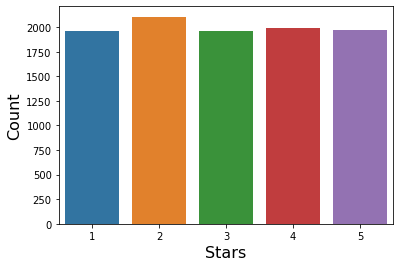

In [20]:
# Lemmatize
print("Body process:", end=" ")
start_time = time()
reviews_train_data.review_body = reviews_train_data.review_body.apply(lemmatize_text)
print_elapsed_minutes(start_time)

print("Title process:", end=" ")
start_time = time()
reviews_train_data.review_title = reviews_train_data.review_title.apply(lemmatize_text)
print_elapsed_minutes(start_time)

weights = np.ones(reviews_train_data.shape[0])
sampled_reviews_train_data = reviews_train_data.sample(n=base_sample, weights=weights, random_state=random_state)
sampled_reviews_train_data = sampled_reviews_train_data[["review_title", "review_body", "stars"]]
print(f"Size of the sample: {sampled_reviews_train_data.shape}")

g = sns.countplot(x="stars", data=sampled_reviews_train_data)
g.set_xlabel("Stars", fontsize=fontsize)
g.set_ylabel("Count", fontsize=fontsize)
plt.show()

Para las reseñas positivas (agrupando las calificaciones de 4 y 5) y negativas (calificaciones 1 y 2) observamos:

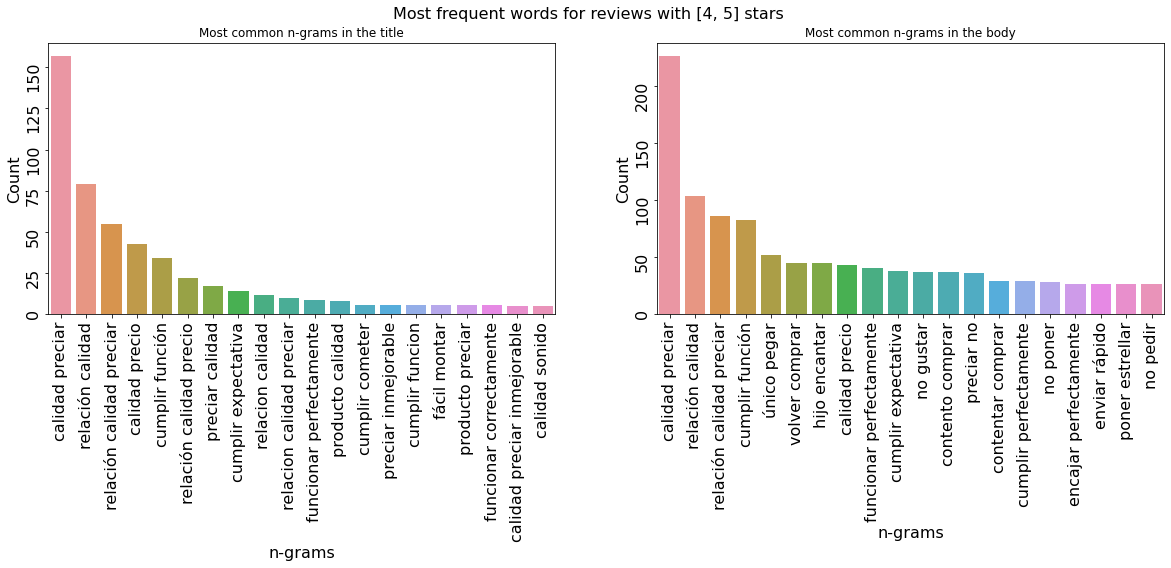

In [21]:
common_words_count(df=sampled_reviews_train_data, stars=[4,5], ngram_range=(2,3), max_count=20, fontsize=fontsize, figsize=(20, 5))

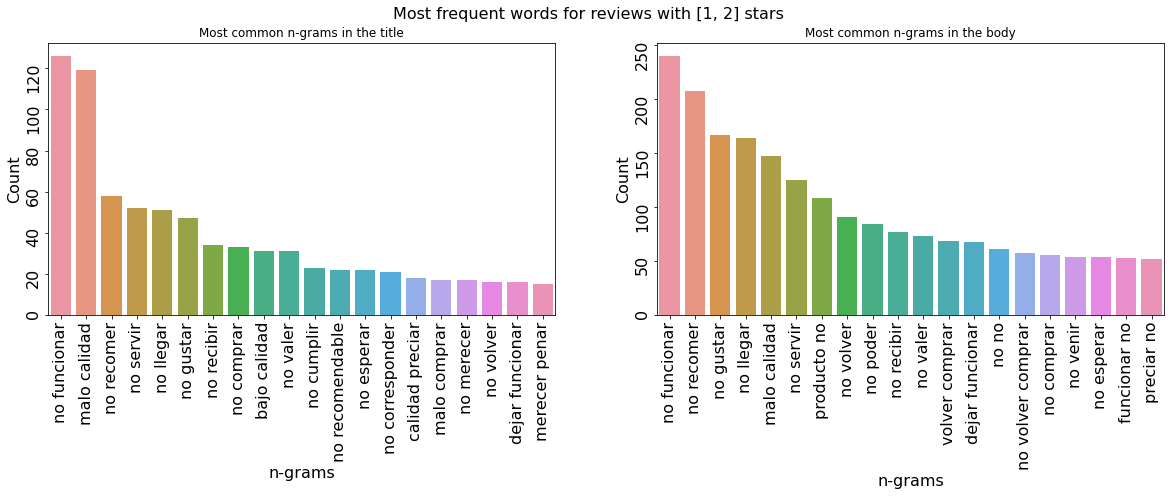

In [22]:
common_words_count(df=sampled_reviews_train_data, stars=[1,2], ngram_range=(2,3), max_count=20, fontsize=fontsize, figsize=(20, 5))

Se puede notar que algunos n-gramas como `no gustar` y `preciar no` son compartidas entre las reseñas positivas y negativas (en diferentes proporciones) pero esto queda fuera de lo comprendido por este estudio.

### Modelo Benchmark

Como modelo benchmark usaremos:

* El método bag of words donde se hará un conteo de las palabras de los cuerpos de las reseñas.
* Un modelo `SVC`.
* Método One vs Rest para problemas multi-clase.

La estrategia a seguir se describirá a continuación:

1. Se considerará únicamente el texto en el cuerpo de la reseña.
1. Se creará una instancia de `CountVectorizer` para procesar y vectorizar la información tanto de `train` como de `dev`.
1. Se entrenará el modelo `SVC` y `RandomForestClassifier` con la muestra de los datos de entrenamiento.
1. Una vez el entrenamiento culmine, se usarán los datos `dev` para obtener el `accuracy` del modelo.

In [23]:
# Create counter
benchmark_count_vectorizer = CountVectorizer(max_features = max_features, ngram_range=(1, 1))

# Transform
print("Vectorizing process:", end=" ")
%time matrix_body_train = benchmark_count_vectorizer.fit_transform(sampled_reviews_train_data.review_body)
X_train_bench = matrix_body_train.toarray()
y_train_bench = sampled_reviews_train_data.stars

Vectorizing process: Wall time: 176 ms


In [24]:
reviews_dev_data = pd.read_json("./data/dataset_es_dev.json", lines=True)

# Lemmatize
print("Body process:", end=" ")
%time reviews_dev_data.review_body = reviews_dev_data.review_body.apply(lemmatize_text)
print("Title process:", end=" ")
%time reviews_dev_data.review_title = reviews_dev_data.review_title.apply(lemmatize_text)

reviews_dev_data = reviews_dev_data[["review_title", "review_body", "stars"]]

Body process: Wall time: 51.9 s
Title process: Wall time: 33.4 s


In [25]:
print("Vectorizing process:", end=" ")
%time matrix_body_dev = benchmark_count_vectorizer.transform(reviews_dev_data.review_body)
X_dev_bench = matrix_body_dev.toarray()
y_dev_bench = reviews_dev_data.stars

Vectorizing process: Wall time: 85 ms


Abajo se encuentran dos funciones que serán de utilidad para visualizar los resultados y entrenar los modelos:

In [26]:
# Plot confusion matrix
def confusion_multi(ytest,y_pred):
    names = ["1","2", "3", "4", "5"]
    cm = confusion_matrix(ytest,y_pred)
    f,ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, linewidth=.5, linecolor="r", fmt=".0f", ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

# Train model
def train_benchmark_model(model, traindata, devdata):
    X_train, y_train = traindata
    X_dev, y_dev = devdata

    # Training classifier
    print("Training", end=" ")
    start_time = time()
    model.fit(X_train, y_train)
    print_elapsed_minutes(start_time)

    # Predict
    print("Predicting", end=" ")
    start_time = time()
    predictions = model.predict(X_dev)
    print_elapsed_minutes(start_time)

    # Accuracy dev
    accuracy = accuracy_score(y_dev, predictions)
    print(f"Accuracy for dev set: {100 * accuracy:.2f}%")

    confusion_multi(y_dev, predictions)

Ejecutamos la función para entrenar y obtener los resultados del modelo.

Training 4.04 min
Predicting 3.69 min
Accuracy for dev set: 41.76%


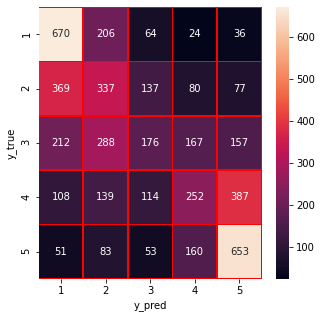

In [27]:
# # One vs Rest + SVC
train_benchmark_model(OneVsRestClassifier(SVC(random_state=random_state), n_jobs=-1), (X_train_bench, y_train_bench), (X_dev_bench, y_dev_bench))

Training 1.02 min
Predicting 0.02 min
Accuracy for dev set: 39.30%


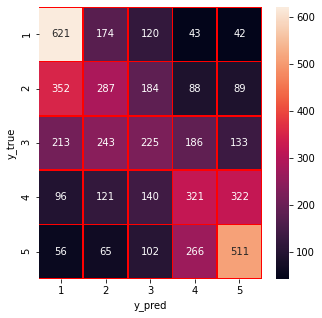

In [28]:
# One vs Rest + Random Forest
train_benchmark_model(OneVsRestClassifier(RandomForestClassifier(random_state=random_state, n_jobs=-1), n_jobs=-1), (X_train_bench, y_train_bench), (X_dev_bench, y_dev_bench))

Como **benchmark** se tomará:

* Modelo: `SVC` con valores por defecto.
* Accuracy obtenido: `41%`.

### Creación del modelo y optimización de hiperparámetros.

Considerando los recursos de hardware disponibles al momento de realizar este análisis, se seguirán los siguientes pasos:

1. Los datos de entrenamiento a usar serán la muestra de 10.000 registros previamente obtenidos. Los mismos serán usados para la optimización de hiperparámetros.
1. Se estudiarán tanto el modelo `SVC` y `RandomForestClassifier`. 
1. Para la vectorización se implementarán las clases `CountVectorizer` y `TfidfVectorizer`.

Debido al gran volumen de los datos y para monitorear el tiempo de entrenamiento para cada combinación durante la fase de optimización de hiperparámetros, en lugar de usar modelos como `GridSearchCV` se usará:

* Ciclos `for`.
* Se optimizarán los hipermarámetros entrenando con `train` y validando con `dev`.
* El `accuracy` real del modelo se estimará comparando con los datos de `test`.

A continuación se muestran dos métodos:

* `confusion_binary` que nos ayudará al final del análisis.
* `train_model` adaptación de `train_benchmark_model` para poder contemplar los casos mencionados anteriormente a esta lista.

In [29]:
def confusion_binary(ytest,y_pred):
    names = ["0","1"]
    cm = confusion_matrix(ytest,y_pred)
    f,ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, linewidth=.5, linecolor="r", fmt=".0f", ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

def train_model(data, classifier, title_vectorizer, body_vectorizer, return_results=True, print_confusion_matrix=False, binary=False):
    start_time = time()
    
    train_data, dev_data = data
    title_words_train = title_vectorizer.fit_transform(train_data.review_title)
    body_words_train = body_vectorizer.fit_transform(train_data.review_body)
    
    X_train = sparse.hstack((title_words_train, body_words_train)) 
    y_train = train_data.stars

    # model generation
    classifier.fit(X_train, y_train)

    title_words_dev = title_vectorizer.transform(dev_data.review_title)
    body_words_dev = body_vectorizer.transform(dev_data.review_body)

    X_dev = sparse.hstack((title_words_dev, body_words_dev))
    y_dev = dev_data.stars

    # Predict
    predictions = classifier.predict(X_dev)
    print_elapsed_minutes(start_time)
    
    # Accuracy dev
    accuracy = accuracy_score(y_dev, predictions)
    print(f"Accuracy for dev set: {100 * accuracy:.2f}%\n")

    if print_confusion_matrix:
        confusion_binary(y_dev, predictions) if binary else confusion_multi(y_dev, predictions)

    if return_results:
        return accuracy

Comenzando el análisis para el modelo `SVC`:

In [30]:
ngram_ranges = [(1,1), (1,2)]
Cs=[1.0, 2.0]
kernels=["linear", "rbf"]
degrees=[2, 3]
vectorizer_strategies = ["count", "tf_idf"]
combinations = []
best_params_svc = {
    "accuracy": 0
}

for ngram_range in ngram_ranges:
    for C in Cs:
        for kernel in kernels:
            for degree in degrees:
                for vectorizer_strategy in vectorizer_strategies:
                    combinations.append({
                        "ngram_range": ngram_range,
                        "C": C,
                        "kernel": kernel,
                        "degree": degree,
                        "vectorizer_strategy": vectorizer_strategy
                    })

total_combinations = len(combinations)
for loop_number, combination in enumerate(combinations):
    print(f"Loop {loop_number + 1}/{total_combinations} ({combination}) =>", end=" ")
    
    if combination["vectorizer_strategy"] == "tf_idf":
        body_vectorizer = TfidfVectorizer(max_features = max_features, ngram_range=combination["ngram_range"])
        title_vectorizer = TfidfVectorizer(max_features = max_features, ngram_range=combination["ngram_range"])
    else:
        body_vectorizer = CountVectorizer(max_features = max_features, ngram_range=combination["ngram_range"])
        title_vectorizer = CountVectorizer(max_features = max_features, ngram_range=combination["ngram_range"])
    
    classifier = OneVsRestClassifier(SVC(C=combination["C"], kernel=combination["kernel"], degree=combination["degree"], random_state=random_state), n_jobs=-1)
    model_accuracy = train_model((sampled_reviews_train_data, reviews_dev_data), classifier, title_vectorizer, body_vectorizer)
    
    if best_params_svc["accuracy"] < model_accuracy:
        best_params_svc["accuracy"] = model_accuracy
        best_params_svc["params"] = combination
        best_params_svc["classifier"] = classifier
        best_params_svc["body_vectorizer"] = body_vectorizer
        best_params_svc["title_vectorizer"] = title_vectorizer

print("\nBest Params:")
best_params_svc

Loop 1/32 ({'ngram_range': (1, 1), 'C': 1.0, 'kernel': 'linear', 'degree': 2, 'vectorizer_strategy': 'count'}) => 0.41 min
Accuracy for dev set: 43.38%

Loop 2/32 ({'ngram_range': (1, 1), 'C': 1.0, 'kernel': 'linear', 'degree': 2, 'vectorizer_strategy': 'tf_idf'}) => 0.31 min
Accuracy for dev set: 44.62%

Loop 3/32 ({'ngram_range': (1, 1), 'C': 1.0, 'kernel': 'linear', 'degree': 3, 'vectorizer_strategy': 'count'}) => 0.40 min
Accuracy for dev set: 43.38%

Loop 4/32 ({'ngram_range': (1, 1), 'C': 1.0, 'kernel': 'linear', 'degree': 3, 'vectorizer_strategy': 'tf_idf'}) => 0.31 min
Accuracy for dev set: 44.62%

Loop 5/32 ({'ngram_range': (1, 1), 'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'vectorizer_strategy': 'count'}) => 0.55 min
Accuracy for dev set: 44.34%

Loop 6/32 ({'ngram_range': (1, 1), 'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'vectorizer_strategy': 'tf_idf'}) => 0.56 min
Accuracy for dev set: 45.66%

Loop 7/32 ({'ngram_range': (1, 1), 'C': 1.0, 'kernel': 'rbf', 'degree': 3, 'vectorize

{'accuracy': 0.4586,
 'params': {'ngram_range': (1, 2),
  'C': 1.0,
  'kernel': 'rbf',
  'degree': 2,
  'vectorizer_strategy': 'tf_idf'},
 'classifier': OneVsRestClassifier(estimator=SVC(degree=2, random_state=1990), n_jobs=-1),
 'body_vectorizer': TfidfVectorizer(max_features=2000, ngram_range=(1, 2)),
 'title_vectorizer': TfidfVectorizer(max_features=2000, ngram_range=(1, 2))}

Continuando con `RandomForestClassifier`:

In [31]:
ngram_ranges = [(1,1), (1,2)]
n_estimators_array = [100, 200]
criterions = ["gini", "entropy"]
max_depths = [10, 50, 100]
vectorizer_strategies = ["count", "tf_idf"]
combinations = []
best_params_random_forest = {
    "accuracy": 0
}

for n_estimators in n_estimators_array:
    for criterion in criterions:
        for max_depth in max_depths:
            for ngram_range in ngram_ranges:
                for vectorizer_strategy in vectorizer_strategies:
                    combinations.append({
                        "n_estimators": n_estimators,
                        "criterion": criterion,
                        "max_depth": max_depth,
                        "ngram_range": ngram_range,
                        "vectorizer_strategy": vectorizer_strategy
                    })

total_combinations = len(combinations)
for loop_number, combination in enumerate(combinations):
    print(f"Loop {loop_number + 1}/{total_combinations} ({combination}) =>", end=" ")

    if combination["vectorizer_strategy"] == "tf_idf":
        body_vectorizer = TfidfVectorizer(max_features = max_features, ngram_range=combination["ngram_range"])
        title_vectorizer = TfidfVectorizer(max_features = max_features, ngram_range=combination["ngram_range"])
    else:
        body_vectorizer = CountVectorizer(max_features = max_features, ngram_range=combination["ngram_range"])
        title_vectorizer = CountVectorizer(max_features = max_features, ngram_range=combination["ngram_range"])

    classifier = OneVsRestClassifier(RandomForestClassifier(max_depth=combination["max_depth"], criterion=combination["criterion"], n_estimators=combination["n_estimators"], n_jobs=-1, random_state=random_state), n_jobs=-1)
    model_accuracy = train_model((sampled_reviews_train_data, reviews_dev_data), classifier, title_vectorizer, body_vectorizer)

    if best_params_random_forest["accuracy"] < model_accuracy:
        best_params_random_forest["accuracy"] = model_accuracy
        best_params_random_forest["params"] = combination
        best_params_random_forest["classifier"] = classifier
        best_params_random_forest["body_vectorizer"] = body_vectorizer
        best_params_random_forest["title_vectorizer"] = title_vectorizer

print("\nBest Params for Random Forest:")
best_params_random_forest

Loop 1/48 ({'n_estimators': 100, 'criterion': 'gini', 'max_depth': 10, 'ngram_range': (1, 1), 'vectorizer_strategy': 'count'}) => 0.03 min
Accuracy for dev set: 42.32%

Loop 2/48 ({'n_estimators': 100, 'criterion': 'gini', 'max_depth': 10, 'ngram_range': (1, 1), 'vectorizer_strategy': 'tf_idf'}) => 0.03 min
Accuracy for dev set: 42.76%

Loop 3/48 ({'n_estimators': 100, 'criterion': 'gini', 'max_depth': 10, 'ngram_range': (1, 2), 'vectorizer_strategy': 'count'}) => 0.03 min
Accuracy for dev set: 42.62%

Loop 4/48 ({'n_estimators': 100, 'criterion': 'gini', 'max_depth': 10, 'ngram_range': (1, 2), 'vectorizer_strategy': 'tf_idf'}) => 0.03 min
Accuracy for dev set: 42.08%

Loop 5/48 ({'n_estimators': 100, 'criterion': 'gini', 'max_depth': 50, 'ngram_range': (1, 1), 'vectorizer_strategy': 'count'}) => 0.05 min
Accuracy for dev set: 44.58%

Loop 6/48 ({'n_estimators': 100, 'criterion': 'gini', 'max_depth': 50, 'ngram_range': (1, 1), 'vectorizer_strategy': 'tf_idf'}) => 0.05 min
Accuracy for 

{'accuracy': 0.4498,
 'params': {'n_estimators': 200,
  'criterion': 'entropy',
  'max_depth': 50,
  'ngram_range': (1, 1),
  'vectorizer_strategy': 'count'},
 'classifier': OneVsRestClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                      max_depth=50,
                                                      n_estimators=200,
                                                      n_jobs=-1,
                                                      random_state=1990),
                     n_jobs=-1),
 'body_vectorizer': CountVectorizer(max_features=2000),
 'title_vectorizer': CountVectorizer(max_features=2000)}

Podemos observar:

* El rendimiento del modelo `SVC` (45.86%) fue mejor que `RandomForestClassifier` (44,98%). Sin embargo, su diferencia no supera el 1%.
* El entrenamiento y validación con el modelo `SVC` es aproximadamente 14 veces mayor que el de `RandomForestClassifier`.

Teniendo en cuenta lo anteriormente mencionado, el modelo a elegir para entrenar el modelo con los datos de entrenamiento completos será **`RandomForestClassifier`**. Esto debido a lo veloz de su entrenamiento sin perjudicar en gran medida su desempeño (en producción menos tiempo de cómputo implica más ahorro de dinero).

Comenzando con el entrenamiento con el dataset completo con los hiperparámetros elegidos:

In [32]:
best_params_random_forest

{'accuracy': 0.4498,
 'params': {'n_estimators': 200,
  'criterion': 'entropy',
  'max_depth': 50,
  'ngram_range': (1, 1),
  'vectorizer_strategy': 'count'},
 'classifier': OneVsRestClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                      max_depth=50,
                                                      n_estimators=200,
                                                      n_jobs=-1,
                                                      random_state=1990),
                     n_jobs=-1),
 'body_vectorizer': CountVectorizer(max_features=2000),
 'title_vectorizer': CountVectorizer(max_features=2000)}

Training time: 9.05 min
Accuracy for dev set: 48.18%



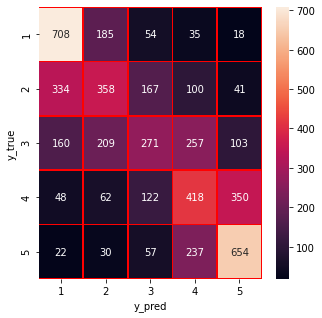

In [33]:
rf_best_params = best_params_random_forest["params"]
rf_body_vectorizer = CountVectorizer(max_features = max_features, ngram_range=rf_best_params["ngram_range"])
rf_title_vectorizer = CountVectorizer(max_features = max_features, ngram_range=rf_best_params["ngram_range"])
rf_classifier = OneVsRestClassifier(RandomForestClassifier(max_depth=rf_best_params["max_depth"], criterion=rf_best_params["criterion"], n_estimators=rf_best_params["n_estimators"], n_jobs=-1, random_state=random_state), n_jobs=-1)
print("Training time:", end=" ")
train_model((reviews_train_data, reviews_dev_data), rf_classifier, rf_title_vectorizer, rf_body_vectorizer, return_results=False, print_confusion_matrix=True)

Estimando el `accuracy` real del modelo con el conjunto de datos de `test`:

Body process: Wall time: 1min 8s
Title process: Wall time: 39.3 s
Predict: 0.02 min
Accuracy for test set: 48.28%



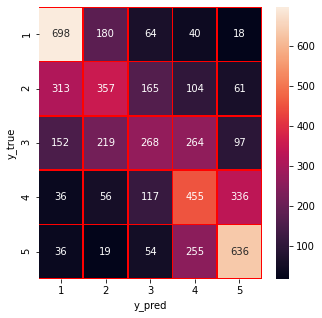

In [34]:
# Import
reviews_test_data = pd.read_json("./data/dataset_es_test.json", lines=True)

# Process
print("Body process:", end=" ")
%time reviews_test_data.review_body = reviews_test_data.review_body.apply(lemmatize_text)
print("Title process:", end=" ")
%time reviews_test_data.review_title = reviews_test_data.review_title.apply(lemmatize_text)
reviews_test_data = reviews_test_data[["review_title", "review_body", "stars"]]

title_words_test = rf_title_vectorizer.transform(reviews_test_data.review_title)
body_words_test = rf_body_vectorizer.transform(reviews_test_data.review_body)

X_test = sparse.hstack((title_words_test, body_words_test))
y_test = reviews_test_data.stars

# Predict
print("Predict:", end=" ")
start_time = time()
predictions = rf_classifier.predict(X_test)
print_elapsed_minutes(start_time)

# Evaluation
accuracy_test = accuracy_score(y_test, predictions)
print(f"Accuracy for test set: {100 * accuracy_test:.2f}%\n")

confusion_multi(y_test, predictions)

En cuyo caso obtenemos un accuracy de aproximadamente `48%` para el modelo de predicción.

Usando las propiedades del algoritmo, se puede obtener las palabras que más usadas para realizar las predicciones. Debajo, se pueden observar las palabras más usadas para predecir los casos de 1 y 5 estrellas respectivamente:

In [35]:
all_body_words = [f"{word} (body)" for word in rf_body_vectorizer.get_feature_names()]
all_title_words = [f"{word} (title)" for word in rf_title_vectorizer.get_feature_names()]
all_words = [*all_title_words, *all_body_words]

def plot_feature_importance(all_words, importances, use_case):
    indices = np.argsort(importances)[::-1]
    indices = indices[:30]
    selected_words = [all_words[i] for i in indices]
    selected_importances = importances[indices]

    plt.figure(figsize = (15,8))
    g = sns.barplot(x=selected_words, y=selected_importances)
    g.set_title(f"Most relevant words for predicting {use_case}", fontsize=fontsize)
    g.set_xlabel("Words", fontsize=fontsize)
    g.set_ylabel("Importance", fontsize=fontsize)
    g.tick_params(axis="x", labelsize=fontsize, labelrotation=80)
    plt.show()

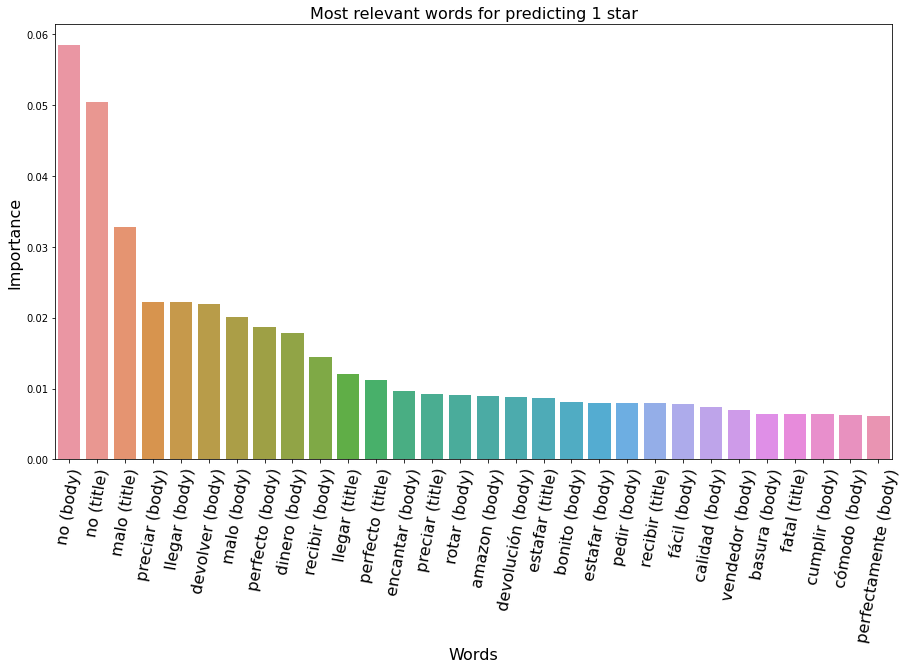

In [36]:
importances = rf_classifier.estimators_[0].feature_importances_

plot_feature_importance(all_words, importances, "1 star")

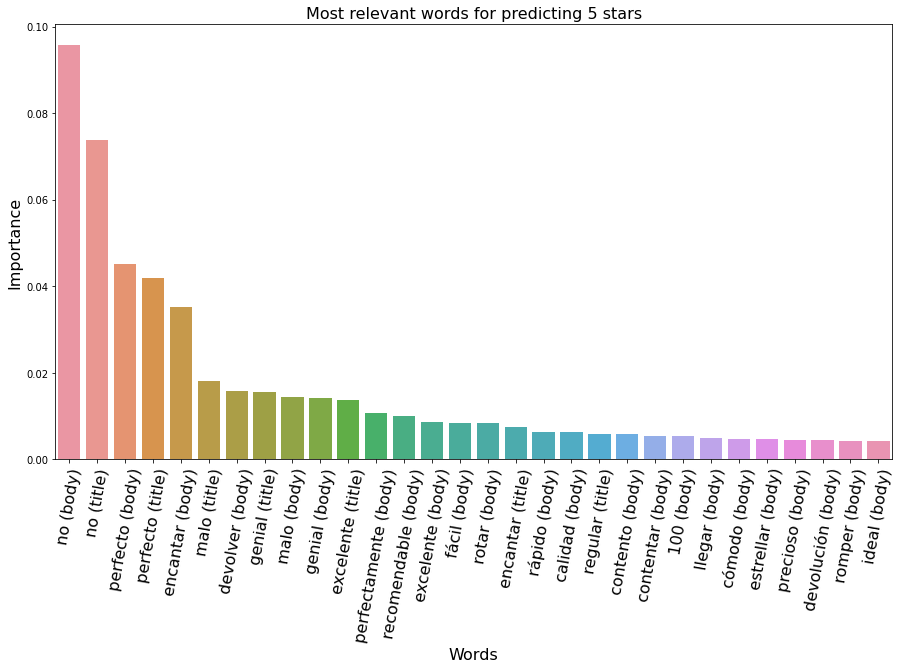

In [37]:
importances = rf_classifier.estimators_[4].feature_importances_

plot_feature_importance(all_words, importances, "5 stars")

Se puede observar que efectivamente el primer gráfico se centra en palabras negativas (reseña de 1 estrella) y el segundo en palabras que podrían considerarse positivas (reseña de 5 estrellas). Sin embargo, también se debe notar que ambos gráficos contienen las mismas palabras por lo que puede explicarse las confusiones del modelo en la matriz. 

En la matriz de confusión del conjunto `test`, se puede observar algo intersante. El algoritmo "confunde" en mayor medida, las calificaciones 4 y 5 y las 1 y 2.
Esto puede llevar a pensar que puede tener sentido cambiar de enfoque y en lugar de tratar el problema con multi-clase, tratarlo como binario (reseñas positivas vs reseñas negativas).

Para ello, se eliminará las reseñas con 3 estrellas y se agruparán en una misma clase a las reseñas con 4 y 5 estrellas como positivas y 1 y 2 como negativas.

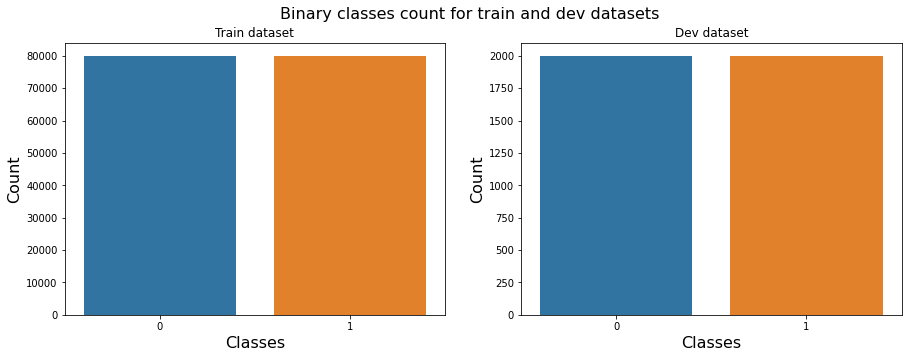

In [38]:
binary_train_data = reviews_train_data[reviews_train_data.stars.isin([1, 2, 4, 5])].copy()
binary_train_data.stars.replace([1,2,4,5], [1,1,0,0], inplace=True)

binary_dev_data = reviews_dev_data[reviews_dev_data.stars.isin([1, 2, 4, 5])].copy()
binary_dev_data.stars.replace([1,2,4,5], [1,1,0,0], inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle(f"Binary classes count for train and dev datasets", fontsize=fontsize)


g = sns.countplot(x="stars", data=binary_train_data, ax=axes[0])
g.set_xlabel("Classes", fontsize=fontsize)
g.set_ylabel("Count", fontsize=fontsize)
axes[0].set_title("Train dataset")

g = sns.countplot(x="stars", data=binary_dev_data, ax=axes[1])
g.set_xlabel("Classes", fontsize=fontsize)
g.set_ylabel("Count", fontsize=fontsize)
axes[1].set_title("Dev dataset")

plt.show()

Comenzando el entrenamiento:

Training time: 1.48 min
Accuracy for dev set: 86.40%



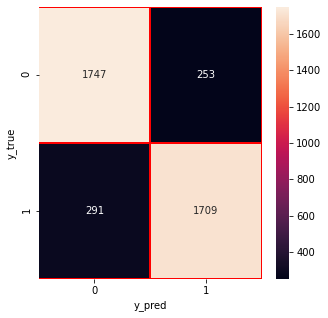

In [39]:
binary_body_vectorizer = CountVectorizer(max_features = max_features, ngram_range=rf_best_params["ngram_range"])
binary_title_vectorizer = CountVectorizer(max_features = max_features, ngram_range=rf_best_params["ngram_range"])
binary_random_forest = RandomForestClassifier(max_depth=rf_best_params["max_depth"], criterion=rf_best_params["criterion"], n_estimators=rf_best_params["n_estimators"], n_jobs=-1, random_state=random_state)
print("Training time:", end=" ")
train_model((binary_train_data, binary_dev_data), binary_random_forest, binary_title_vectorizer, binary_body_vectorizer, return_results=False, print_confusion_matrix=True, binary=True)

Para los datos de `test`:

In [40]:
all_body_words_binary = [f"{word} (body)" for word in binary_body_vectorizer.get_feature_names()]
all_title_words_binary = [f"{word} (title)" for word in binary_title_vectorizer.get_feature_names()]
all_words_binary = [*all_title_words_binary, *all_body_words_binary]

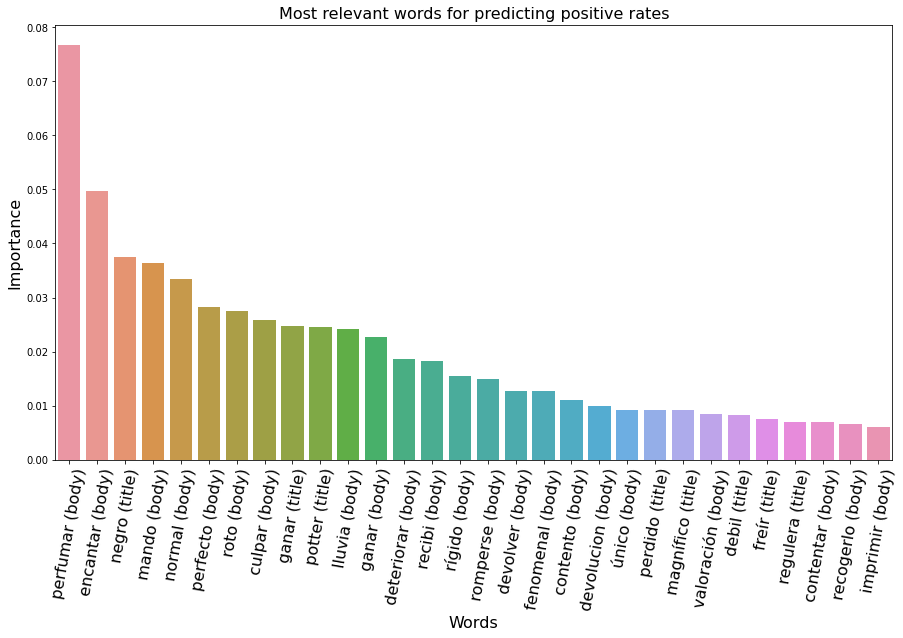

In [41]:
importances = binary_random_forest.estimators_[0].feature_importances_

plot_feature_importance(all_words, importances, "positive rates")

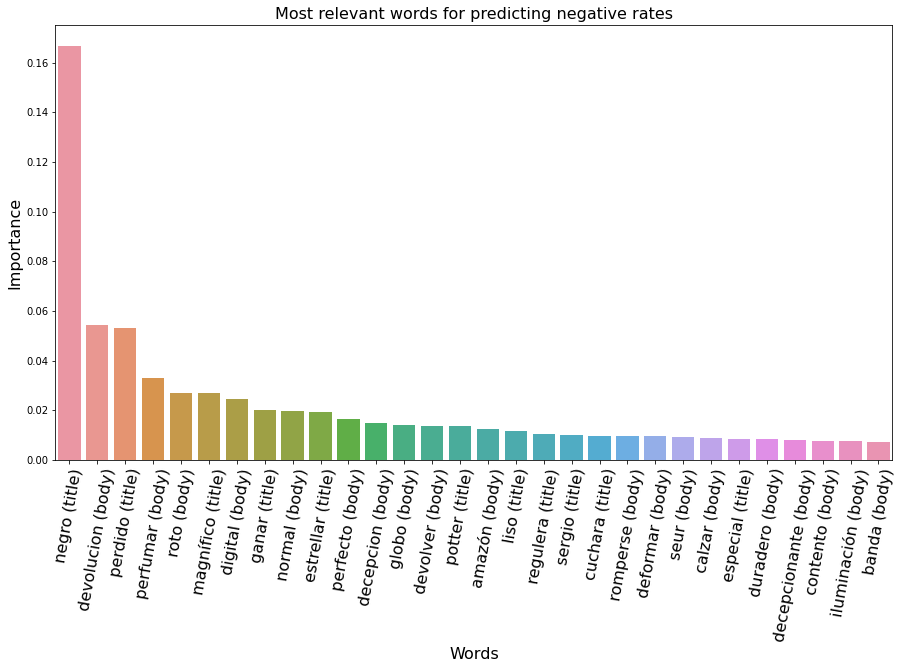

In [42]:
importances = binary_random_forest.estimators_[1].feature_importances_

plot_feature_importance(all_words, importances, "negative rates")

### Análisis de los resultados

Un breve resumen podrá ser de ayuda para comparar los resultados obtenidos con lo esperado:

* **Problema planteado:** Predecir las estrellas de la reseña a partir del contenido del mismo.
* **Resultados esperados:** Obtener un modelo que pueda predecir la cantidad de estrallas que un usuario puede asignar a una compra a partir de su reseña. Para ello, se espera que asocie palabras con connotación positiva (perfecto, maravilloso, entregado, etc) con calificaciones altas como 4 y 5 y las palabras negativas (malo, pérdida, defectuoso, etc) con calificaciones bajas como 1 y 2.

El modelo de Random Forest justo con la estrategia One vs Rest provee 5 modelos, cada uno de ellos dedicados a centrarse en cada calificación. En los gráficos `Most relevant words for predicting 1 star` y `Most relevant words for predicting 5 stars` se puede notar la predominancia de palabras con connotación negativa (devolver, estafar o fatal) y positiva (perfecto, genial o excelente), respectivamente. Sin embargo, considerando que la comparación trata de las dos calificaciones extramas, se esperaba que las diferencias fueran mucho más marcadas. Existen palabras no esperadas como "perfecto" en las negativas y "malo" en las positivas. Estas coincidencias entre ambos modelos explica el `accuracy` obtenido (`48%`).

Se podría esperar también que el cuerpo de la reseña, sirva mejor como guía para la clasificación lo cual concuerda con los resultados graficados. No se puede olvidar que en posiciones altas de importancia, algunas palabras en particular poseen un peso considerable si se encuentran en el título como `perfecto` o `no`.

Otro resultado esperable, es si se cambia la perspectiva del problema y se piensa como uno binario (reseñas positivas vs negativas) el nivel de aciertos aumentaría debido a que no sería necesaria una granularidad al momento de realizar las predicciones. La matriz de confusión resultante del problema multi-clase da pistas que esto puede ser cierto ya que las confusiones se concentran en su mayoria en las regiones 4 y 5 (positivas) y 1 y 2 (negativas). Al hacer los ajustes para convertir el problema en uno binario se obtiene un aumento significativo en el `accuracy` al `86%` confirmando así nuestra hipótesis.

### Conclusiones

* El mejor modelo obtenido fue el de `RandomForestClassifier` con los siguientes hiperparámetros:
    * `n_estimators`: 200.
    * `criterion`: 'entropy'.
    * `max_depth`: 50.
* Para la vectorización, la estrategia de `Bag of Words` tuve mejor desempeño que el `TF-IDF` con Random Forest. En este caso con monogramas.
* El desempeño estimado del modelo es de `48%` de aciertos (`accuracy`).
* Un [artículo](https://arxiv.org/pdf/2010.02573v1.pdf) publicado sobre este dataset, indica que usando un algoritmo llamado `BERT` y un entrenamiento de `10hrs` aproximadamente, puede llegar a obtener un `accuracy` de `58%` por lo que el análisis presentado en este notebook puede ser mejorado haciendo uso de modelos más avanzados.
* La matriz de confusión del modelo arroja pistas que indican que el problema puede ser tratado como binario: reseñas positivas (4 y 5) y negativas (1 y 2). Haciendo esto, se puede notar una mejora significativa en el `accuracy` pasando de `48%` a `86%`.
* El modelo de Random Forest nos facilita mucho la interpretación de los resultados obtenidos. En las gráficas de palabras más importantes para realizar las predicciones se puede apreciar que para los casos negativos predominan palabras que se pueden asociar con sentimientos negativos. Lo mismo puede decirse del caso de las reseñas positivas.
* Un punto adicional a considerar en las gráficas de las palabras más importantes para la predicción son las coincidencias (aunque en diferentes proporciones) para los pasos positivos y negativos como `devolucion`, `normal` o `perfecto` que pueden estar causando las confusiones del modelo.
* Posibles mejoras que pueden implementarse sobre este análisis:
    * El uso de la estrategia multi-clase `One vs One`.
    * Investigar el efecto sobre el desempeño del modelo al filtrar más rigurosamente las palabras (ejemplo: eliminar la palabra `no` de las reseñas positivas).
    * Incluir en el modelo las categorías de las reseñas.
    * Investigar y aplicar modelos más avanzados (como redes neuronales).